In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge, Lasso, BayesianRidge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor, BaggingRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

import numpy as np
import random
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random.seed(20)

Cargo dataset, convierto variables categóricas y numéricas y divido en datos de entrenamiento y test

In [ ]:
dataset = pd.read_csv('final_car_data.csv', sep=";")
dataset = dataset.drop(columns=["id", "Marca", "Url"])
dataset = dataset.rename(columns={'Transmision': 'Automatico', 'Tipo de vendedor': 'Particular'})
dataset['Automatico'].replace(['manual', 'automatic'], [0, 1], inplace=True)
dataset['Particular'].replace(['particular', 'profesional'], [0, 1], inplace=True)

In [ ]:
stacked = dataset[['Modelo']].stack()
dataset[['Modelo']] = pd.Series(stacked.factorize()[0], index=stacked.index).unstack()
dataset

,Modelo,Km,Cilindrada,Caballos,Año,Combustible,Provincia,Automatico,Traccion,Tipo,Puertas,Color,Asientos,Particular,Precio
0,0,162000,1998,124,2012,diesel,Barcelona,0,delantera,berlina,4,blanco,5,0,7900
1,1,64707,1496,111,2020,gasolina,Valencia,0,delantera,berlina,5,gris,5,1,15350
2,2,40971,998,69,2018,gasolina,Madrid,0,delantera,berlina,3,blanco,4,1,12890
3,3,15313,1798,122,2022,hibrido,Madrid,1,delantera,berlina,5,negro,5,1,23999
4,4,33911,1798,122,2022,hibrido,Madrid,1,delantera,berlina,5,marron,5,1,24999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,21,120000,2494,120,2009,diesel,Córdoba,0,total,pick up,2,blanco,2,1,21900
6756,1,260000,1298,87,2005,gasolina,Madrid,0,delantera,berlina,3,negro,5,0,3000
6757,21,61000,2393,150,2017,diesel,Córdoba,0,total,pick up,4,blanco,5,1,24900
6758,14,131000,2755,177,2017,diesel,Córdoba,1,total,4x4 suv,5,azul,7,1,36800


In [ ]:
data = pd.get_dummies(dataset, columns=['Provincia','Combustible', 'Traccion', 'Tipo', 'Color'])
data

,Modelo,Km,Cilindrada,Caballos,Año,Automatico,Puertas,Asientos,Particular,Precio,...,Color_beige,Color_blanco,Color_granate,Color_gris,Color_marron,Color_morado,Color_naranja,Color_negro,Color_rojo,Color_verde
0,0,162000,1998,124,2012,0,4,5,0,7900,...,0,1,0,0,0,0,0,0,0,0
1,1,64707,1496,111,2020,0,5,5,1,15350,...,0,0,0,1,0,0,0,0,0,0
2,2,40971,998,69,2018,0,3,4,1,12890,...,0,1,0,0,0,0,0,0,0,0
3,3,15313,1798,122,2022,1,5,5,1,23999,...,0,0,0,0,0,0,0,1,0,0
4,4,33911,1798,122,2022,1,5,5,1,24999,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6755,21,120000,2494,120,2009,0,2,2,1,21900,...,0,1,0,0,0,0,0,0,0,0
6756,1,260000,1298,87,2005,0,3,5,0,3000,...,0,0,0,0,0,0,0,1,0,0
6757,21,61000,2393,150,2017,0,4,5,1,24900,...,0,1,0,0,0,0,0,0,0,0
6758,14,131000,2755,177,2017,1,5,7,1,36800,...,0,0,0,0,0,0,0,0,0,0


Esta función toma como argumento el dataset, divide en datos de entrenamiento y test, escala los valores y devuelve los datasets necesarios para todos los modelos

In [ ]:
def preprocess_data(data):
  y = data[["Precio"]]
  X = data.loc[:, data.columns != 'Precio']

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 4)

  scaler = preprocessing.StandardScaler().fit(X_train)
  X_train_scaled = scaler.transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  #Creo un dataframe con lo escalado para poder hacer selección de características después
  X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
  X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

  train_features = X_train_scaled.copy(deep=True)
  test_features = X_test_scaled.copy(deep=True)

  train_features_2 = X_train_scaled[X_train_scaled.columns.drop(list(X_train_scaled.filter(regex='Provincia')))]
  test_features_2 = X_test_scaled[X_test_scaled.columns.drop(list(X_train_scaled.filter(regex='Provincia')))]

  train_features_3 = train_features_2[train_features_2.columns.drop(list(train_features_2.filter(regex='Tipo')))]
  test_features_3 = test_features_2[test_features_2.columns.drop(list(test_features_2.filter(regex='Tipo')))]
  train_features_3 = train_features_2[train_features_2.columns.drop(list(train_features_2.filter(regex='Puertas')))]
  test_features_3 = test_features_2[test_features_2.columns.drop(list(test_features_2.filter(regex='Puertas')))]
  train_features_3 = train_features_2[train_features_2.columns.drop(list(train_features_2.filter(regex='Color')))]
  test_features_3 = test_features_2[test_features_2.columns.drop(list(test_features_2.filter(regex='Color')))]

  return y_train, y_test, train_features, test_features, train_features_2, test_features_2, train_features_3, test_features_3

In [ ]:
y_train, y_test, train_features, test_features, train_features_2, test_features_2, train_features_3, test_features_3 = preprocess_data(data)

Función para imprimir los resultados del modelo

In [ ]:
def printResults(model_name, y_test, predictions):
    meanSquaredError = mean_squared_error(y_test, predictions)
    rootMeanSquaredError = sqrt(meanSquaredError)
    absolute_error = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions)

    print ("\nResultados: ", model_name)
    print("RMSE: ", round(rootMeanSquaredError, 4))
    print("r2: ", round(r2, 4))
    print("MAPE: ", round(mape*100, 4), "%")

Folds para validación cruzada

In [ ]:
n_folds = 5

## 1. Regresión lineal

In [ ]:
def createModelLinearRegression(y_train, y_test, train_features, test_features):
    start_time = time.time()

    lr = LinearRegression()
    lr.fit(train_features, y_train)
    predictions_lr = lr.predict(test_features)

    end_time = time.time()

    printResults('Regresión Lineal', y_test, predictions_lr)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

#### Sin selección de características

In [ ]:
createModelLinearRegression(y_train, y_test, train_features, test_features)


Resultados:  Regresión Lineal
RMSE:  3378.2405
r2:  0.8751
MAPE:  20.3494 %
Tiempo de ejecución:  0.0851


#### Con selección de características (elimino variable Provincia)

In [ ]:
createModelLinearRegression(y_train, y_test, train_features_2, test_features_2)


Resultados:  Regresión Lineal
RMSE:  3383.5442
r2:  0.8747
MAPE:  20.5294 %
Tiempo de ejecución:  0.0225


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

## 2. Ridge Regression

In [ ]:
def createModelRidgeRegression(y_train, y_test, train_features, test_features):

    start_time = time.time()

    ridge = Ridge()

    params = {"alpha": [0.001, 0.01, 0.1, 1, 10, 100]}

    grid = GridSearchCV(ridge, param_grid=params, scoring='r2')
    grid.fit(train_features, y_train)

    ridge = Ridge(grid.best_params_['alpha'])
    ridge.fit(train_features, y_train)
    predictions_rr = ridge.predict(test_features)

    end_time = time.time()

    print('Ridge Regression - mejores parámetros: ', grid.best_params_)
    printResults('Ridge Regression', y_test, predictions_rr)

    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

#### Sin selección de características

In [ ]:
grid_rr = createModelRidgeRegression(y_train, y_test, train_features, test_features)

Ridge Regression - mejores parámetros:  {'alpha': 10}

Resultados:  Ridge Regression
RMSE:  3373.0417
r2:  0.8755
MAPE:  20.4056 %
Tiempo de ejecución:  1.0644


#### Con selección de características (elimino variable Provincia)

In [ ]:
_ = createModelRidgeRegression(y_train, y_test, train_features_2, test_features_2)

Ridge Regression - mejores parámetros:  {'alpha': 10}

Resultados:  Ridge Regression
RMSE:  3383.8698
r2:  0.8747
MAPE:  20.5076 %
Tiempo de ejecución:  0.7814


### El mejor modelo es aquel que contine todas las variables

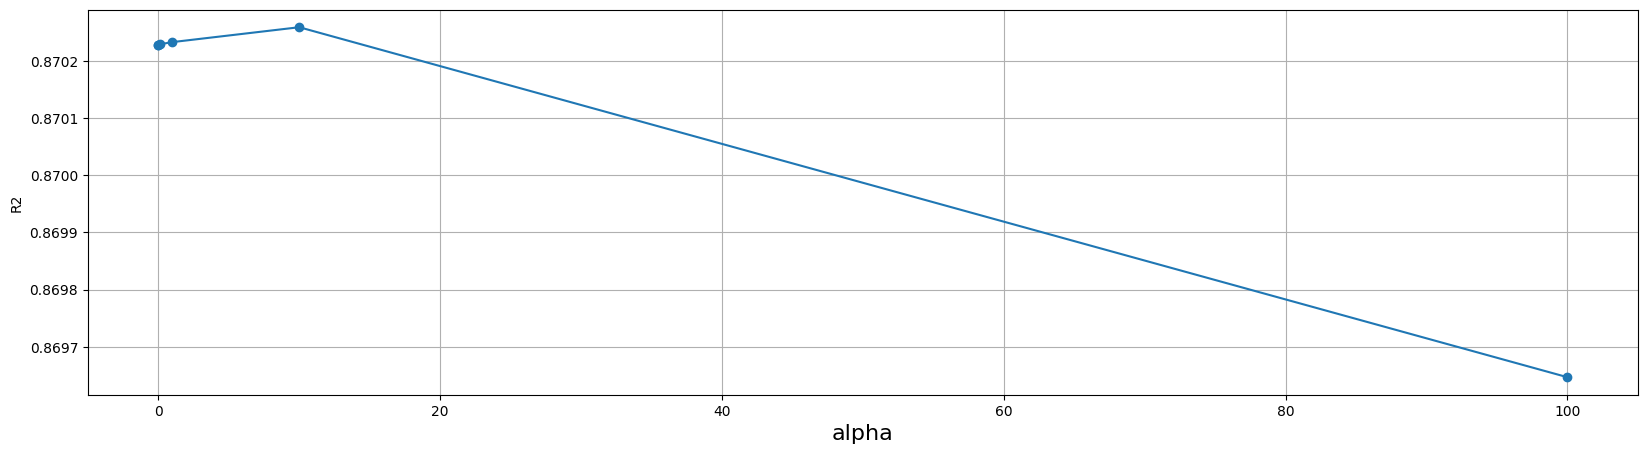

In [ ]:
_= plt.figure(figsize=(20,5))
scores_test = np.array(grid_rr.cv_results_['mean_test_score'])
plt.plot([0.001, 0.01, 0.1, 1, 10, 100], scores_test, '-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('R2')
plt.grid(True)
plt.show()

## 3. Árbol de regresión

In [ ]:
def createModelDecisionTree(y_train, y_test, train_features, test_features):
    start_time = time.time()

    dt = DecisionTreeRegressor(random_state=0)

    params = {"max_depth": range(1, 15),
              "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}

    grid = GridSearchCV(dt, param_grid=params, scoring='r2', cv=n_folds, return_train_score=True)
    grid.fit(train_features, y_train)

    best_model_dt = grid.best_estimator_
    predictions_dt = best_model_dt.predict(test_features)

    end_time = time.time()

    print('Arbol de regresión - mejores parámetros: ', grid.best_params_)
    printResults('Árbol de regresión', y_test, predictions_dt)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

#### Sin selección de características

In [ ]:
_ = createModelDecisionTree(y_train, y_test, train_features, test_features)

Arbol de regresión - mejores parámetros:  {'criterion': 'poisson', 'max_depth': 10}

Resultados:  Árbol de regresión
RMSE:  2488.4511
r2:  0.9182
MAPE:  10.8317 
Tiempo de ejecución:  107.6747


#### Con selección de características (elimino variable Provincia)

In [ ]:
_ = createModelDecisionTree(y_train, y_test, train_features_2, test_features_2)

Arbol de regresión - mejores parámetros:  {'criterion': 'poisson', 'max_depth': 8}

Resultados:  Árbol de regresión
RMSE:  2589.5626
r2:  0.9266
MAPE:  10.5228 %
Tiempo de ejecución:  61.8911


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

In [ ]:
grid_dt = createModelDecisionTree(y_train, y_test, train_features_3, test_features_3)

Arbol de regresión - mejores parámetros:  {'criterion': 'poisson', 'max_depth': 10}

Resultados:  Árbol de regresión
RMSE:  2469.6636
r2:  0.9332
MAPE:  9.9962 %
Tiempo de ejecución:  43.0761


#### Influencia de max_depth en R2

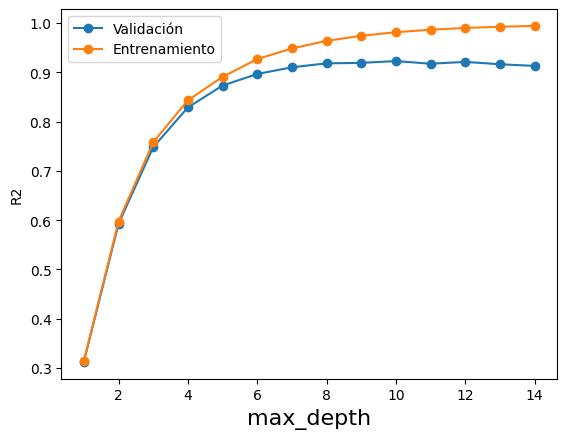

In [ ]:
dt = DecisionTreeRegressor(random_state=0)
params = {"max_depth": range(1, 15),
          "criterion": ['poisson']}

grid = GridSearchCV(dt, param_grid=params, scoring='r2', cv=n_folds, return_train_score=True)
grid.fit(train_features, y_train)

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(range(1,15), scores_test, '-o', label='Validación')
plt.plot(range(1,15), scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('R2'.format(n_folds))
plt.legend(loc='best')
plt.show()

## 4. Random Forest

In [ ]:
def createModelRandomForest(y_train, y_test, train_features, test_features):
    start_time = time.time()

    rf = RandomForestRegressor(random_state=0, n_estimators=100)
    params = {"max_depth": range(1, 15),
              "criterion": ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']}

    grid = GridSearchCV(rf, param_grid=params, scoring='r2', return_train_score=True)
    grid.fit(train_features, y_train)

    best_model_rf = grid.best_estimator_
    predictions_rf = best_model_rf.predict(test_features)

    end_time = time.time()

    print('Random Forest - mejores parámetros: ', grid.best_params_)
    printResults('Random Forest', y_test, predictions_rf)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

#### Sin selección de características

In [ ]:
_ = createModelRandomForest(y_train, y_test, train_features, test_features)

Random Forest - mejores parámetros:  {'criterion': 'absolute_error', 'max_depth': 14}

Resultados:  Random Forest
RMSE:  2119.836
r2:  0.9506
MAPE:  8.2876 %
Tiempo de ejecución:  4388.6254


#### Con selección de características (elimino variable Provincia)

In [ ]:
_ = createModelRandomForest(y_train, y_test, train_features_2, test_features_2)

Random Forest - mejores parámetros:  {'criterion': 'absolute_error', 'max_depth': 14}

Resultados:  Random Forest
RMSE:  2119.836
r2:  0.9507
MAPE:  8.2746 %
Tiempo de ejecución:  2544.6752


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

In [ ]:
grid_rf = createModelRandomForest(y_train, y_test, train_features_3, test_features_3)

Random Forest - mejores parámetros:  {'criterion': 'squared_error', 'max_depth': 12}

Resultados:  Random Forest
RMSE:  2118.1908
r2:  0.9508
MAPE:  8.2568 %
Tiempo de ejecución:  1828.9884


Influencia de max_depth en R2

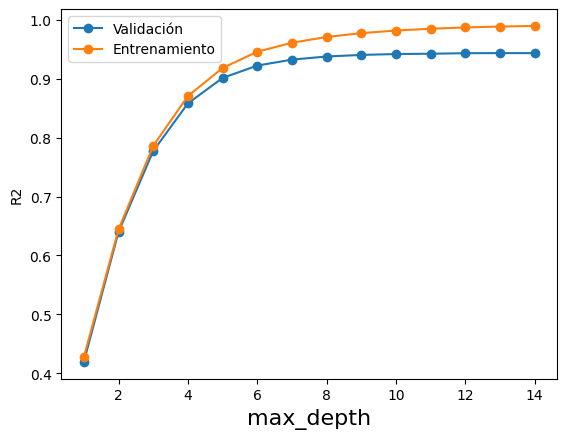

In [ ]:
rf = RandomForestRegressor(random_state=0)
params = {"max_depth": range(1,15),
          "criterion": ['squared_error']}

grid = GridSearchCV(rf, param_grid=params, scoring='r2', cv=n_folds, return_train_score=True)
grid.fit(train_features, y_train)

scores_test = np.array(grid.cv_results_['mean_test_score'])
scores_train = np.array(grid.cv_results_['mean_train_score'])
plt.plot(range(1,15), scores_test, '-o', label='Validación')
plt.plot(range(1,15), scores_train, '-o', label='Entrenamiento')
plt.xlabel('max_depth', fontsize=16)
plt.ylabel('R2'.format(n_folds))
plt.legend(loc='best')
plt.show()

## 5. SVM

In [ ]:
def createModelSVM(y_train, y_test, train_features, test_features):
    start_time = time.time()

    params = {'C': [1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['linear', 'rbf', 'sigmoid']}

    svm = SVR()
    grid = GridSearchCV(svm, param_grid=params, scoring='r2', cv=n_folds)
    grid.fit(train_features, y_train)

    best_params_svm = grid.best_params_
    best_model_svm = grid.best_estimator_

    predictions_svm = best_model_svm.predict(test_features)

    end_time = time.time()

    print('SVM - mejores parámetros: ', grid.best_params_)
    printResults('SVM', y_test, predictions_svm)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

#### Sin selección de características

In [ ]:
_ = createModelSVM(y_train, y_test, train_features, test_features)

SVM - mejores parámetros:  {'C': 100, 'gamma': 1, 'kernel': 'linear'}

Resultados:  SVM
RMSE:  3517.9983
r2:  0.8645
MAPE:  19.4971 %
Tiempo de ejecución:  424.441


#### Con selección de características (elimino variable Provincia)

In [ ]:
grid_svm = createModelSVM(y_train, y_test, train_features_2, test_features_2)

SVM - mejores parámetros:  {'C': 100, 'gamma': 1, 'kernel': 'linear'}

Resultados:  SVM
RMSE:  3506.9549
r2:  0.8654
MAPE:  19.504 %
Tiempo de ejecución:  316.6857


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

In [ ]:
_ = createModelSVM(y_train, y_test, train_features_3, test_features_3)

SVM - mejores parámetros:  {'C': 100, 'gamma': 1, 'kernel': 'linear'}

Resultados:  SVM
RMSE:  3530.1502
r2:  0.8636
MAPE:  19.6173 %
Tiempo de ejecución:  321.219


#### Influencia de C, gamma y kernel

In [ ]:
results = grid_svm.cv_results_

params = results['params']
scores = results['mean_test_score']

for diccionario, valor in zip(params, scores):
    diccionario['score'] = valor

#Como influye C
diccionario1 = [diccionario for diccionario in params if diccionario.get('gamma') == 1 and diccionario.get('kernel') == 'linear']

#Como influye gamma
diccionario2 = [diccionario for diccionario in params if diccionario.get('C') == 100 and diccionario.get('kernel') == 'linear']

#Como influye kernel
diccionario3 = [diccionario for diccionario in params if diccionario.get('C') == 100 and diccionario.get('gamma') == 1]


cost_list = [diccionario['C'] for diccionario in diccionario1]
score_list_1  = [diccionario['score'] for diccionario in diccionario1]

gamma_list = [diccionario['gamma'] for diccionario in diccionario2]
score_list_2  = [diccionario['score'] for diccionario in diccionario2]

kernel_list = [diccionario['kernel'] for diccionario in diccionario3]
score_list_3  = [diccionario['score'] for diccionario in diccionario3]

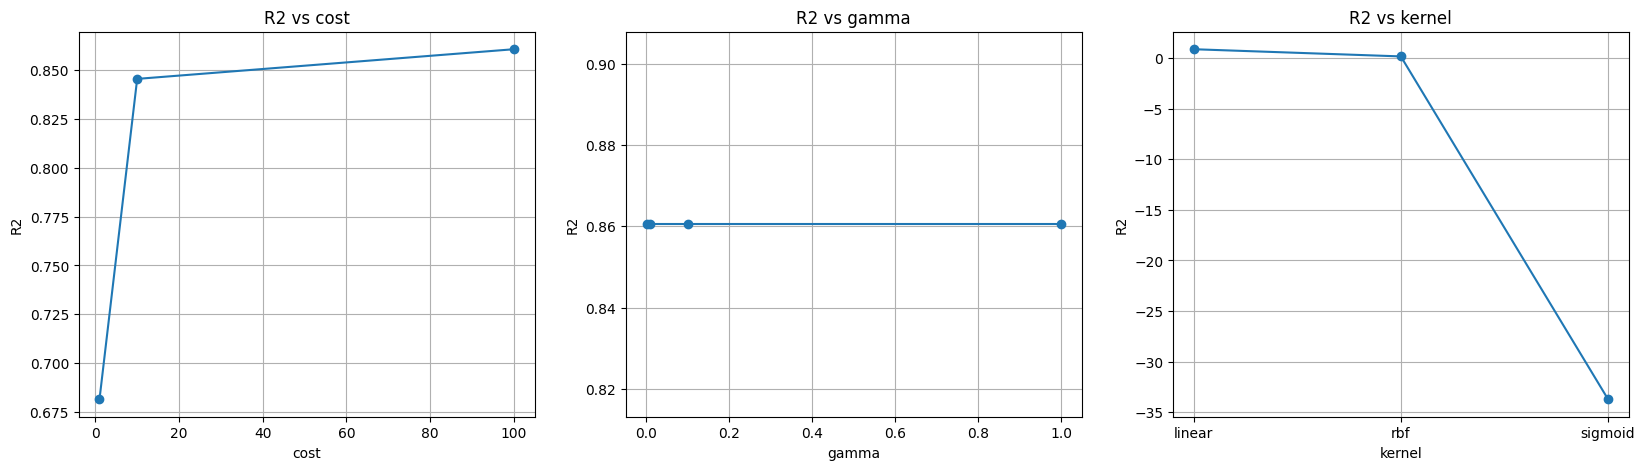

In [ ]:
_= plt.figure(figsize=(20,5))

_ = plt.subplot(1,3,1)
plt.plot(cost_list, score_list_1, marker='o')
plt.xlabel('cost')
plt.ylabel('R2')
plt.title('R2 vs cost')
plt.grid(True)

_ = plt.subplot(1,3,2)
plt.plot(gamma_list, score_list_2, marker='o')
plt.xlabel('gamma')
plt.ylabel('R2')
plt.title('R2 vs gamma')
plt.grid(True)

_ = plt.subplot(1,3,3)
plt.plot(kernel_list, score_list_3, marker='o')
plt.xlabel('kernel')
plt.ylabel('R2')
plt.title('R2 vs kernel')
plt.grid(True)

plt.show()

## 6. AdaBoost Regressor

In [ ]:
def createModelAdaBoost(y_train, y_test, train_features, test_features):
    start_time = time.time()

    params = {'learning_rate': [0.001, 0.01, 0.1, 1],
              'n_estimators': [50, 100, 150, 200]}

    ab = AdaBoostRegressor()
    grid = GridSearchCV(ab, param_grid=params, scoring='r2', cv=n_folds)
    grid.fit(train_features, y_train)

    best_model_ada = grid.best_estimator_
    predictions_ada = best_model_ada.predict(test_features)

    end_time = time.time()

    print('AdaBoost - mejores parámetros: ', grid.best_params_)
    printResults('AdaBoost', y_test, predictions_ada)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

#### Sin selección de características

In [ ]:
_= createModelAdaBoost(y_train, y_test, train_features, test_features)

AdaBoost - mejores parámetros:  {'learning_rate': 0.1, 'n_estimators': 150}

Resultados:  AdaBoost
RMSE:  4030.1432
r2:  0.8222
MAPE:  27.5446 %
Tiempo de ejecución:  138.221


#### Con selección de características (elimino variable Provincia)

In [ ]:
grid_ab = createModelAdaBoost(y_train, y_test, train_features_2, test_features_2)

AdaBoost - mejores parámetros:  {'learning_rate': 0.1, 'n_estimators': 150}

Resultados:  AdaBoost
RMSE:  3940.0344
r2:  0.8301
MAPE:  26.2902 %
Tiempo de ejecución:  86.4498


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

In [ ]:
_= createModelAdaBoost(y_train, y_test, train_features_3, test_features_3)

AdaBoost - mejores parámetros:  {'learning_rate': 0.1, 'n_estimators': 100}

Resultados:  AdaBoost
RMSE:  3992.43
r2:  0.8255
MAPE:  26.8906 %
Tiempo de ejecución:  73.2014


#### Influencia de learning_rate y n_estimators

In [ ]:
results = grid_ab.cv_results_

params = results['params']
scores = results['mean_test_score']

for diccionario, valor in zip(params, scores):
    diccionario['score'] = valor

#Como influye learning rate
diccionario1 = [diccionario for diccionario in params if diccionario.get('n_estimators') == 100]

#Como influye n_estimators
diccionario2 = [diccionario for diccionario in params if diccionario.get('learning_rate') == 0.1]

learning_rate_list = [diccionario['learning_rate'] for diccionario in diccionario1]
score_list_1  = [diccionario['score'] for diccionario in diccionario1]

n_estimators_list = [diccionario['n_estimators'] for diccionario in diccionario2]
score_list_2  = [diccionario['score'] for diccionario in diccionario2]

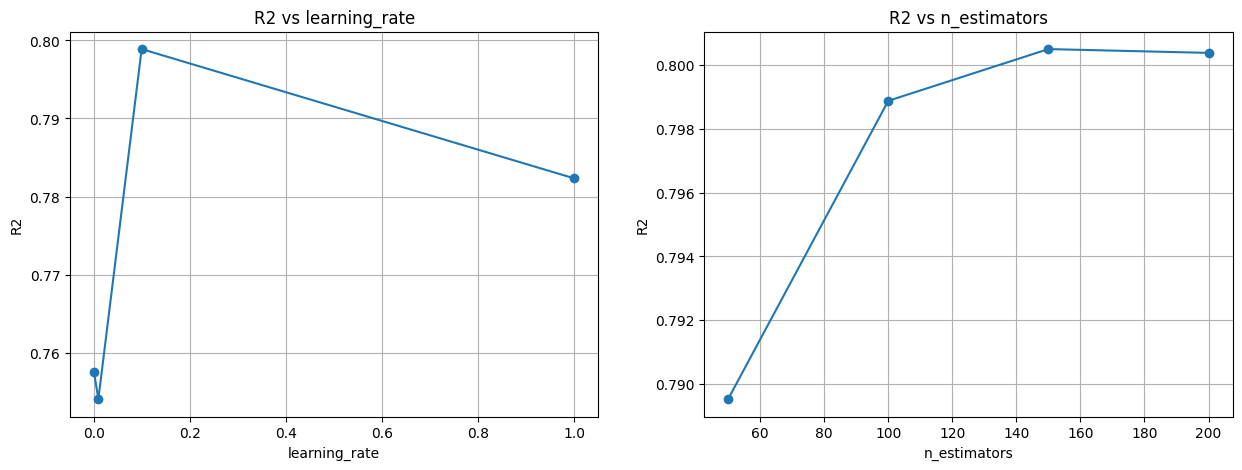

In [ ]:
_= plt.figure(figsize=(15,5))

_ = plt.subplot(1,2,1)
plt.plot(n_estimators_list, score_list_1, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('R2')
plt.title('R2 vs learning_rate')
plt.grid(True)

_ = plt.subplot(1,2,2)
plt.plot(learning_rate_list, score_list_2, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('R2')
plt.title('R2 vs n_estimators')
plt.grid(True)

plt.show()

## 7. LGBM Regressor

In [ ]:
def createModelLGBM(y_train, y_test, train_features, test_features):
    start_time = time.time()

    params = {
          'num_leaves': [10, 20, 30],
          'learning_rate': [0.1, 0.01, 0.001],
          'max_depth': [5, 10, 15, 20]
        }

    lgbm = lgb.LGBMRegressor()

    grid_search = GridSearchCV(estimator=lgbm, param_grid=params, cv=n_folds, scoring='r2')
    grid_search.fit(train_features, y_train)

    best_params_lgbm = grid_search.best_params_
    best_model_lgbm = grid_search.best_estimator_

    predictions_lgbm = best_model_lgbm.predict(test_features)

    end_time = time.time()

    print('LGBM Regressor: ', best_params_lgbm)
    printResults('LGBM Regressor', y_test, predictions_lgbm)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid_search

#### Sin selección de características

In [ ]:
grid_lgbm = createModelLGBM(y_train, y_test, train_features, test_features)

LGBM Regressor:  {'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 30}

Resultados:  LGBM Regressor
RMSE:  2017.4733
r2:  0.9554
MAPE:  7.9697 %
Tiempo de ejecución:  27.459


#### Con selección de características (elimino variable Provincia)

In [ ]:
_ = createModelLGBM(y_train, y_test, train_features_2, test_features_2)

LGBM Regressor:  {'learning_rate': 0.1, 'max_depth': 15, 'num_leaves': 30}

Resultados:  LGBM Regressor
RMSE:  2032.2904
r2:  0.9548
MAPE:  8.0696 %
Tiempo de ejecución:  25.3681


#### Observación de la influencia de los parámetros en los valores de R2

In [ ]:
results = grid_lgbm.cv_results_

params = results['params']
scores = results['mean_test_score']

for diccionario, valor in zip(params, scores):
    diccionario['score'] = valor

#Como influye learning rate
diccionario1 = [diccionario for diccionario in params if diccionario.get('max_depth') == 20 and diccionario.get('num_leaves') == 30]

#Como influye max_depth
diccionario2 = [diccionario for diccionario in params if diccionario.get('num_leaves') == 30 and diccionario.get('learning_rate') == 0.1]

#Como influye num_leaves
diccionario3 = [diccionario for diccionario in params if diccionario.get('max_depth') == 20 and diccionario.get('learning_rate') == 0.1]

In [ ]:
learning_rate_list = [diccionario['learning_rate'] for diccionario in diccionario1]
score_list_1  = [diccionario['score'] for diccionario in diccionario1]

max_depth_list = [diccionario['max_depth'] for diccionario in diccionario2]
score_list_2  = [diccionario['score'] for diccionario in diccionario2]

num_leaves_list = [diccionario['num_leaves'] for diccionario in diccionario3]
score_list_3  = [diccionario['score'] for diccionario in diccionario3]

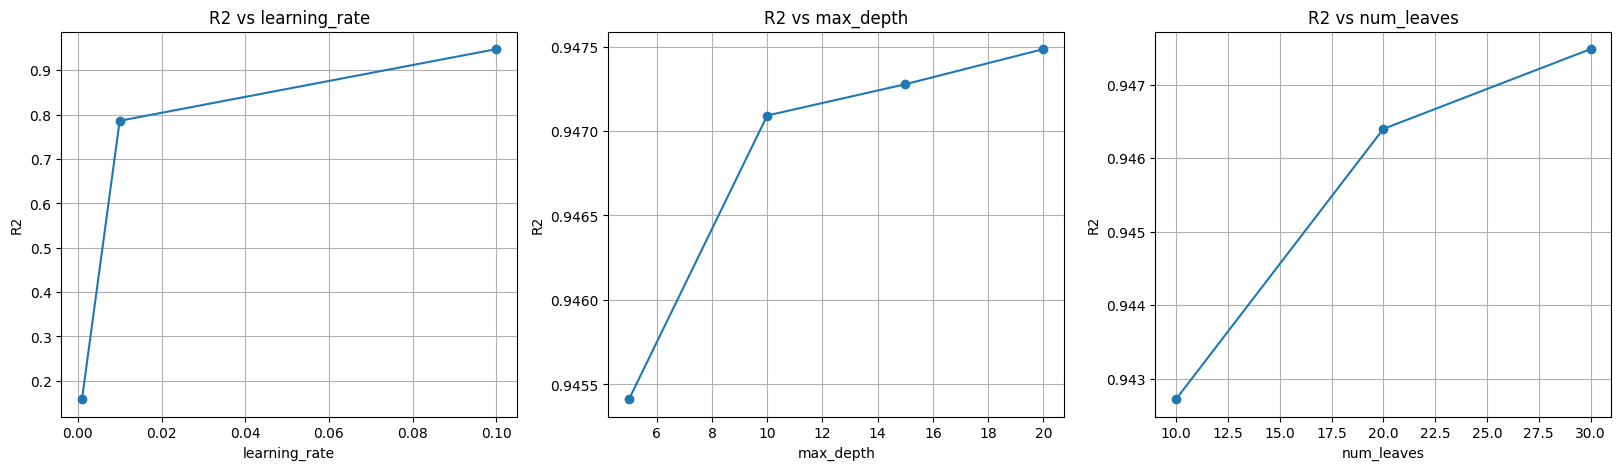

In [ ]:
_= plt.figure(figsize=(20,5))

_ = plt.subplot(1,3,1)
plt.plot(learning_rate_list, score_list_1, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('R2')
plt.title('R2 vs learning_rate')
plt.grid(True)

_ = plt.subplot(1,3,2)
plt.plot(max_depth_list, score_list_2, marker='o')
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.title('R2 vs max_depth')
plt.grid(True)

_ = plt.subplot(1,3,3)
plt.plot(num_leaves_list, score_list_3, marker='o')
plt.xlabel('num_leaves')
plt.ylabel('R2')
plt.title('R2 vs num_leaves')
plt.grid(True)

plt.show()

## 8. XGB Regressor

In [ ]:
def createModelXGB(y_train, y_test, train_features, test_features):
    start_time = time.time()

    estimator = xgb.XGBRegressor()
    params = {
        'max_depth': range (1, 11),
        'n_estimators': range(60, 220, 40),
        #'learning_rate': [0.01, 0.05, 0.1]
        'learning_rate': [0.1]
    }

    grid = GridSearchCV(estimator, param_grid=params, scoring='r2', cv=n_folds)

    grid.fit(train_features, y_train)

    best_params_xgb = grid.best_params_
    best_model_xgb = grid.best_estimator_

    predictions_xgb = best_model_xgb.predict(test_features)

    end_time = time.time()

    print('XGBoost - mejores parámetros: ', best_params_xgb)
    printResults('XGBoost', y_test, predictions_xgb)
    print('Tiempo de ejecución: ', round(end_time-start_time, 4))

    return grid

In [ ]:
grid_xgb = createModelXGB(y_train, y_test, train_features, test_features)

XGBoost - mejores parámetros:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 180}

Resultados:  XGBoost
RMSE:  2019.135
r2:  0.9554
MAPE:  8.3112 %
Tiempo de ejecución:  1054.5318


#### Con selección de características (elimino variable Provincia)

In [ ]:
grid_xgb = createModelXGB(y_train, y_test, train_features_2, test_features_2)

XGBoost - mejores parámetros:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 140}

Resultados:  XGBoost
RMSE:  1973.1257
r2:  0.9574
MAPE:  8.2602 %
Tiempo de ejecución:  623.9305


#### Con selección de características (elimino variable Provincia, Tipo, Puertas y Color)

In [ ]:
_ = createModelXGB(y_train, y_test, train_features_3, test_features_3)

XGBoost - mejores parámetros:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 180}

Resultados:  XGBoost
RMSE:  1993.8775
r2:  0.9565
MAPE:  8.2928 %
Tiempo de ejecución:  382.452


Influencia de los hiperparámetros en los valores de R2

In [ ]:
results = grid_xgb.cv_results_

params = results['params']
scores = results['mean_test_score']

for diccionario, valor in zip(params, scores):
    diccionario['score'] = valor

#Como influye learning rate
diccionario1 = [diccionario for diccionario in params if diccionario.get('max_depth') == 5 and diccionario.get('n_estimators') == 140]

#Como influye max_depth
diccionario2 = [diccionario for diccionario in params if diccionario.get('n_estimators') == 140 and diccionario.get('learning_rate') == 0.1]

#Como influye n_estimators
diccionario3 = [diccionario for diccionario in params if diccionario.get('max_depth') == 5 and diccionario.get('learning_rate') == 0.1]

learning_rate_list = [diccionario['learning_rate'] for diccionario in diccionario1]
score_list_1  = [diccionario['score'] for diccionario in diccionario1]

max_depth_list = [diccionario['max_depth'] for diccionario in diccionario2]
score_list_2  = [diccionario['score'] for diccionario in diccionario2]

n_estimators_list = [diccionario['n_estimators'] for diccionario in diccionario3]
score_list_3  = [diccionario['score'] for diccionario in diccionario3]

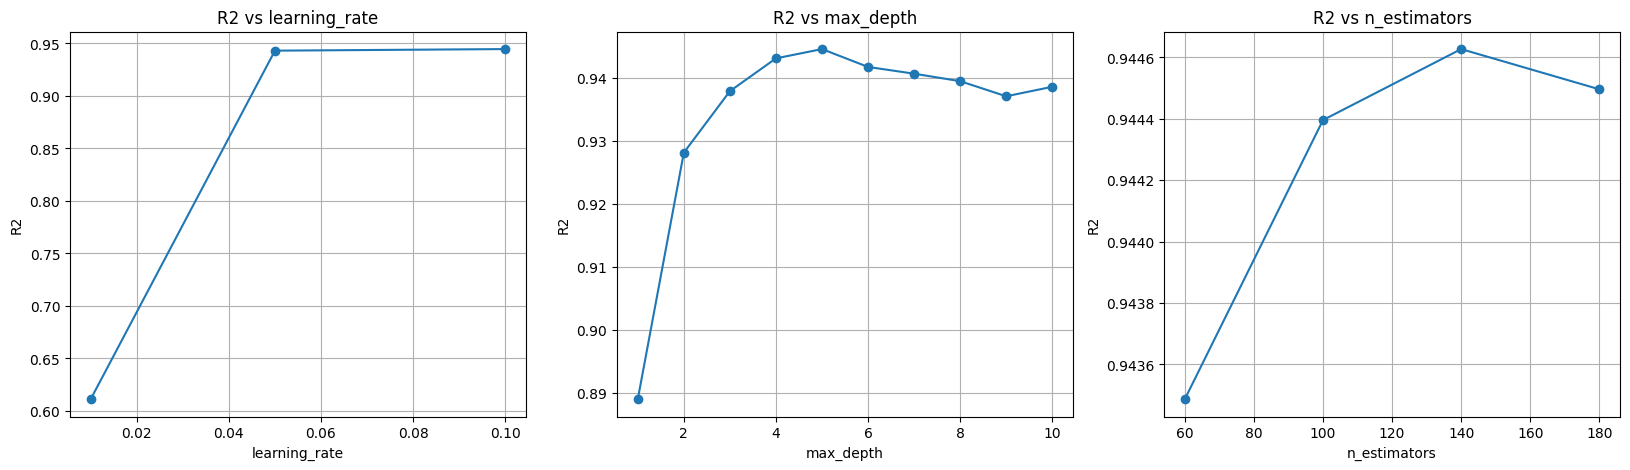

In [ ]:
_= plt.figure(figsize=(20,5))

_ = plt.subplot(1,3,1)
plt.plot(learning_rate_list, score_list_1, marker='o')
plt.xlabel('learning_rate')
plt.ylabel('R2')
plt.title('R2 vs learning_rate')
plt.grid(True)

_ = plt.subplot(1,3,2)
plt.plot(max_depth_list, score_list_2, marker='o')
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.title('R2 vs max_depth')
plt.grid(True)

_ = plt.subplot(1,3,3)
plt.plot(n_estimators_list, score_list_3, marker='o')
plt.xlabel('n_estimators')
plt.ylabel('R2')
plt.title('R2 vs n_estimators')
plt.grid(True)

plt.show()

## Eliminación de outliers

### Creación de modelos para predecir los coches más comunes
#### Solo selecciono los que tienen mayor número de unidades a la venta

In [ ]:
data2 = data.copy(deep=True)
data2 = data2[data2['Modelo'].isin([4, 1, 5, 10, 3])]
data2 = data2.reset_index(drop=True)
data2

,Modelo,Km,Cilindrada,Caballos,Año,Automatico,Puertas,Asientos,Particular,Precio,...,Color_beige,Color_blanco,Color_granate,Color_gris,Color_marron,Color_morado,Color_naranja,Color_negro,Color_rojo,Color_verde
0,1,64707,1496,111,2020,0,5,5,1,15350,...,0,0,0,1,0,0,0,0,0,0
1,3,15313,1798,122,2022,1,5,5,1,23999,...,0,0,0,0,0,0,0,1,0,0
2,4,33911,1798,122,2022,1,5,5,1,24999,...,0,0,0,0,1,0,0,0,0,0
3,1,74468,1497,100,2013,1,5,5,1,10999,...,0,1,0,0,0,0,0,0,0,0
4,5,115551,1798,136,2017,1,5,5,1,14699,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4688,3,5,1798,122,2022,1,5,5,1,27490,...,0,0,0,1,0,0,0,0,0,0
4689,3,245000,1995,116,2004,0,5,5,1,3200,...,0,0,0,0,0,0,0,0,0,0
4690,1,212000,1329,101,2011,0,5,5,0,6000,...,1,0,0,0,0,0,0,0,0,0
4691,1,260000,1298,87,2005,0,3,5,0,3000,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
y_train, y_test, train_features, test_features, train_features_2, test_features_2, train_features_3, test_features_3 = preprocess_data(data2)

In [ ]:
_ = createModelXGB(y_train, y_test, train_features, test_features)

XGBoost - mejores parámetros:  {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 140}

Resultados:  XGBoost
RMSE:  1461.0179
r2:  0.9664
MAPE:  6.5925 %
Tiempo de ejecución:  351.3694


In [ ]:
_ = createModelLGBM(y_train, y_test, train_features_2, test_features_2)

LGBM Regressor:  {'learning_rate': 0.1, 'max_depth': 5, 'num_leaves': 30}

Resultados:  LGBM Regressor
RMSE:  1534.1539
r2:  0.9629
MAPE:  7.0099 %
Tiempo de ejecución:  16.9751


In [ ]:
_ = createModelRandomForest(y_train, y_test, train_features, test_features)

Random Forest - mejores parámetros:  {'criterion': 'absolute_error', 'max_depth': 14}

Resultados:  Random Forest
RMSE:  1457.1936
r2:  0.9665
MAPE:  6.3927 %
Tiempo de ejecución:  2388.0113


### Eliminando outliers en general

In [ ]:
outliers_variables = ['Km', 'Cilindrada', 'Caballos', 'Año']

data_outliers = data2.copy(deep=True)

for variable in outliers_variables:
    mean_var1 = np.mean(data_outliers[variable])
    std_var1 = np.std(data_outliers[variable])
    lower_bound_var1 = mean_var1 - 3 * std_var1
    upper_bound_var1 = mean_var1 + 3 * std_var1
    data_outliers = data_outliers[(data_outliers[variable] > lower_bound_var1) & (data_outliers[variable] < upper_bound_var1)]
    data_outliers = data_outliers.reset_index(drop=True)

data_outliers

,Modelo,Km,Cilindrada,Caballos,Año,Automatico,Puertas,Asientos,Particular,Precio,...,Color_beige,Color_blanco,Color_granate,Color_gris,Color_marron,Color_morado,Color_naranja,Color_negro,Color_rojo,Color_verde
0,1,64707,1496,111,2020,0,5,5,1,15350,...,0,0,0,1,0,0,0,0,0,0
1,3,15313,1798,122,2022,1,5,5,1,23999,...,0,0,0,0,0,0,0,1,0,0
2,4,33911,1798,122,2022,1,5,5,1,24999,...,0,0,0,0,1,0,0,0,0,0
3,1,74468,1497,100,2013,1,5,5,1,10999,...,0,1,0,0,0,0,0,0,0,0
4,5,115551,1798,136,2017,1,5,5,1,14699,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4517,3,5,1798,122,2022,1,5,5,1,27490,...,0,0,0,1,0,0,0,0,0,0
4518,3,245000,1995,116,2004,0,5,5,1,3200,...,0,0,0,0,0,0,0,0,0,0
4519,1,212000,1329,101,2011,0,5,5,0,6000,...,1,0,0,0,0,0,0,0,0,0
4520,1,260000,1298,87,2005,0,3,5,0,3000,...,0,0,0,0,0,0,0,1,0,0


Se decide no seguir con este método debido al gran rango que tienen las variables y a la excesiva pérdida de información
